# Quantify Sampling Quality
The goal in this notebook is to determine the how well a certain trajectory samples all possible environments

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors
from scipy import optimize
import pickle as pkl
import pandas as pd
import numpy as np
import itertools
import gzip
import os

## Import the trajectories, sampling points, and sampling strategies
The bits of data used during the match

In [2]:
random_data = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

In [3]:
channel_data = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

Load the points created by randomly sampling space

In [4]:
sampling_data = pd.read_pickle('sampled_space.pkl.gz')

Load in the projection learned from the sampling space

In [5]:
with gzip.open('manifold.pkl.gz', 'rb') as fp:
    manifold = pkl.load(fp)

Load the feature generator

In [6]:
with open(os.path.join('..', '..', 'featurizers.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)

Load the list of features used to determine the mainfold

In [7]:
with open('manifold_features.pkl', 'rb') as fp:
    X_cols = pkl.load(fp)

Load in the simulation cell

In [8]:
with open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb') as fp:
    simulation_cell = pkl.load(fp)

## Create tool for quantifying degree of sampling
We use an approach of finding what fraction of points in the sampling space we pass "near." 

In [9]:
sampling_proj = manifold.transform(sampling_data[X_cols])

Build a NN finding tool. (I don't normalize, because all the charge density features exist on the same range)

In [10]:
neighbors = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(sampling_proj)

Use 5% of the total variation in the manifold as a metric for distance

In [11]:
thr_dist = (sampling_proj.max() - sampling_proj.min()) * 0.05
print('Threshold distance: {:.2f}'.format(thr_dist))

Threshold distance: 1.39


Plot the random trajectory, to visualize our matching procedure

In [12]:
def get_near_points(dataset):
    """Find the points in the sampling distribution that a trajectory passes near
    
    Args:
        dataset (DataFrame): Sampling of space
    Returns:
        ([int]) Indicies of points in the sampling set the dataset is near
    """
    
    # Get the distances from each point
    dist, ind = neighbors.kneighbors(manifold.transform(dataset[X_cols]))
    
    # Get the indices where the trajectory passes within the threshold distance
    ind = ind[dist < thr_dist]
    
    return sorted(set(np.squeeze(ind).tolist()))

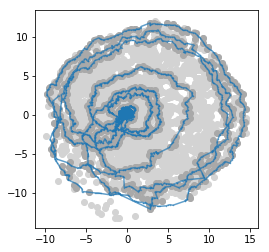

In [13]:
fig, ax = plt.subplots()

# Get the points the random trajectory passes near
hits = get_near_points(random_data)

# Get the projection of the random trajectory
random_proj = manifold.transform(random_data[X_cols])

ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7)

fig.set_size_inches(4, 4)

Measure the performance of the two trajectories

In [14]:
def score_sampling_performance(dataset):
    """Given a dataset, determine the fraction of points in the random sampling space it passes 'near'
    
    Args:
        dataset (DataFrame): Sampling of space
    Returns:
        float - Fraction of sampling space it passes 'near'"""
    
    return len(get_near_points(dataset)) / len(sampling_data)

In [15]:
random_score = score_sampling_performance(random_data)
print('Random trajectory score: {:.1f}%'.format(random_score * 100))

Random trajectory score: 22.4%


In [16]:
print('Channel trajectory score: {:.2f}%'.format(score_sampling_performance(channel_data) * 100))

Channel trajectory score: 0.40%


*Finding*: Yes, the random trajecotry seems to perform better. It samples >10x more of the space

## Can I find a better trajectory?
Only 20% of the search space is not particularly impressive. 

First, get the size of the current trajectory

In [17]:
traj_len = random_data['displacement'].max()
traj_time = len(random_data)
print('The trajectory is {:.1f} a_B and {} timesteps long'.format(
    traj_len, traj_time
))

The trajectory is 140.0 a_B and 9800 timesteps long


Make a function for optimizing the trajectory

In [18]:
def generate_trajectory(start_pos, direction, velocity, 
                       traj_len=traj_len, nsteps=traj_time):
    """Generate a trajectory given starting position, and direction
    
    Args:
        starting_pos ([float]*3): Starting position in cartesian coordinates
        direction ([float]*2): Polar angle, azimuthal angle in radians
        velocity (float): Magnitude of velocity
        traj_len (float): Length of trajectory
        nsteps (int): Number of steps in trajectory
    Returns:
        (DataFrame) Position, velocity, and features for each timestep
    """
    # Generate the projectile velocity vector
    theta, phi = direction
    vel = np.multiply([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi),
                       np.cos(theta)], velocity)
    
    # Make the new trajectory
    traj = np.array(start_pos) + np.dot(vel[:, None],
                                        np.linspace(0, traj_len, nsteps)[None, :]).T
    
    # Turn it into a dataframe
    traj_data = pd.DataFrame(list(itertools.zip_longest(traj, [vel],
                                                       fillvalue=vel)),
                            columns=['position', 'velocity'])
    
    # Compute the features
    featurizers.featurize_dataframe(traj_data, ['position', 'velocity'])
    
    return traj_data

Get the azimuth and inclination of the random trajectory

In [19]:
start = random_data.iloc[0]

In [20]:
theta = np.arccos(start['velocity'][2] / np.linalg.norm(start['velocity']))
phi = np.arctan2(start['velocity'][1], start['velocity'][0])

In [21]:
def test_trajectory(start_pos, direction, velocity=1,
                    traj_len=traj_len, nsteps=traj_time):
    """Compute the score of a certain candidate trajecotry"""
    # Generate the trajectory
    traj_data = generate_trajectory(start_pos, direction,
                                   velocity, traj_len, nsteps)
        
    # Score the trajectory
    return score_sampling_performance(traj_data)

In [22]:
%%time
score = test_trajectory(start['position'], (theta, phi))
print('Example score: {:.2f}%'.format(score * 100))
assert np.isclose(score, random_score).all()

Example score: 22.39%
CPU times: user 16.8 s, sys: 8.54 s, total: 25.4 s
Wall time: 21 s


Optimize the trajectory. Here, I'm using basinhopping naively

In [23]:
x0 = np.hstack((start['position'], (theta, phi)))
print('Initial:', x0)

Initial: [0.         5.74196597 5.74196597 0.76317229 1.22792537]


In [24]:
%%time
opt_result = optimize.basinhopping(lambda x: -test_trajectory(x[:3], x[3:]), x0, niter=100)

CPU times: user 10h 37min 44s, sys: 4h 57min 53s, total: 15h 35min 37s
Wall time: 13h 11min 22s


In [25]:
opt_result

                        fun: -0.24249267578125
 lowest_optimization_result:       fun: -0.24249267578125
 hess_inv: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.00000005, -1.        ],
       [ 0.        ,  0.        ,  0.        , -1.        ,  1.        ]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 2
     njev: 16
   status: 0
  success: True
        x: array([0.46943336, 5.65837398, 5.37229855, 1.14317953, 1.16681684])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev: 2336
                        nit: 100
                       njev: 332
                          x: array([0.4694

In [26]:
res = opt_result.x
print('Optimized:', res)

Optimized: [0.46943336 5.65837398 5.37229855 1.14317953 1.16681684]


In [27]:
opt_start, opt_direction = res[:3], res[3:]

In [28]:
print('Optimized starting:', opt_start)
print('Optimized velcoity:', np.array([np.sin(opt_direction[0]) * np.cos(opt_direction[1]), 
                         np.sin(opt_direction[0]) * np.sin(opt_direction[1]),
                         np.cos(opt_direction[0])]))

Optimized starting: [0.46943336 5.65837398 5.37229855]
Optimized velcoity: [0.35768631 0.8367088  0.41470337]


In [29]:
score = test_trajectory(opt_start, opt_direction)
print('Optimized score: {:.2f}%'.format(score * 100))

Optimized score: 24.25%


Plot the trajectory over time, to see if the optimization is better

In [30]:
steps = np.linspace(0, 1, 40+1)

In [31]:
%%time
random_over_time = [0] + [test_trajectory(start['position'], (theta, phi),
                                          traj_len=traj_len*x, 
                                          nsteps=int(traj_time * x)) 
                          for x in steps[1:]]

CPU times: user 8min 39s, sys: 3min 10s, total: 11min 49s
Wall time: 7min 59s


In [32]:
%%time
opt_over_time = [0] + [test_trajectory(opt_start, opt_direction,
                                       traj_len=traj_len*x,
                                       nsteps=int(traj_time * x)) 
                          for x in steps[1:]]

CPU times: user 8min 34s, sys: 3min 12s, total: 11min 47s
Wall time: 8min 2s


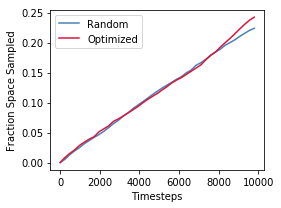

In [33]:
fig, ax = plt.subplots()

ax.plot(steps * traj_time, random_over_time, color='steelblue', label='Random')
ax.plot(steps * traj_time, opt_over_time, color='crimson', label='Optimized')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Fraction Space Sampled')

ax.legend()

fig.set_size_inches(4, 3)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'sampling-comparison.png'), dpi=320)

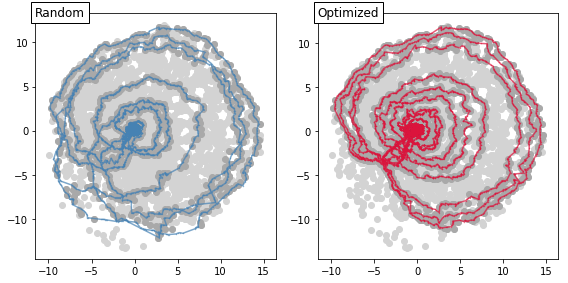

In [34]:
fig, axs = plt.subplots(1, 2)

# Generate the optimized trajectory
opt_data = generate_trajectory(opt_start, opt_direction, 1)

for ax, traj, c, l in zip(axs, [random_data, opt_data],
                      ['steelblue', 'crimson'],
                      ['Random', 'Optimized']):
    # Get the points the random trajectory and passes near
    hits = get_near_points(traj)

    # Get the projection of the random trajectory
    random_proj = manifold.transform(traj[X_cols])

    # Plot the trajectory
    ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
    ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

    ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7,
           color=c)
    
    # Label it
    ax.text(0, 1, l, va='center', transform=ax.transAxes,
            fontsize=12, bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
fig.set_size_inches(8, 4)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'traj_comparison.png'), dpi=320)

*Ideas*: 
- Multiple trajectories
- Penalty for close passes to atoms

## Optimize Several Trajectories Concurrently
It might be better to sample space with two different trajectories. Let's see if we can get better sampling with the same number of steps

In [35]:
def score_multiple_trajectories(trajs, traj_len=traj_len, nsteps=traj_time):
    """Get the amount of space sampled by multiple trajectories
    
    Assumes each trajectory is equal length
    
    Args:
        trajs ([(float)*5]): Coordinates for multiple different trajectories
        traj_len (float): Total distance of the trajectories
        nsteps (int): Total number of steps between each directory
    Return:
        (float) what fraction of the search space was sampled by the trajecotory
        """
    
    # Determine the length of each trajectory
    sub_nsteps = int(nsteps / len(trajs))
    sub_len = traj_len / len(trajs)
    
    # Get the points sampled by each trajectory
    points = set()
    for traj in trajs:
        data = generate_trajectory(traj[:3], traj[3:], 1, sub_len, sub_nsteps)
        points.update(get_near_points(data))
        
    # Return the score
    return len(points) / len(sampling_data)
# Make sure sampling the same trajecotry yields different results
assert np.isclose(score_multiple_trajectories([res], traj_len/2, traj_time/2), score_multiple_trajectories([res, res])).all()

Optimize two trajectories. Use the optimized trajectory and the opposite trajectory running in the opposite direction as a starting point

In [36]:
x0 = np.hstack((opt_start, opt_direction, opt_start, -1 * opt_direction))
print('Initial:', x0)

Initial: [ 0.46943336  5.65837398  5.37229855  1.14317953  1.16681684  0.46943336
  5.65837398  5.37229855 -1.14317953 -1.16681684]


In [37]:
%%time
opt_result = optimize.basinhopping(lambda x: -score_multiple_trajectories(np.reshape(x, (-1, 5))), x0, niter=100)

CPU times: user 1d 4h 18min 32s, sys: 9h 31min 4s, total: 1d 13h 49min 36s
Wall time: 1d 31min 1s


In [38]:
opt_result

                        fun: -0.23419189453125
 lowest_optimization_result:       fun: -0.23419189453125
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0.56012379,  4.69926476,  4.63305072,  2.19829321,  0.44446663,
        0.40713195, -0.44047206,  4.33843943, -2.72721779, -0.92513291])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev

In [39]:
opt_trajs = opt_result.x.reshape((-1, 5))
print('Optimized:', opt_trajs)

Optimized: [[ 0.56012379  4.69926476  4.63305072  2.19829321  0.44446663]
 [ 0.40713195 -0.44047206  4.33843943 -2.72721779 -0.92513291]]


In [40]:
score = score_multiple_trajectories(opt_trajs)
print('Optimized score: {:.2f}%'.format(score * 100))

Optimized score: 23.42%


Compare the sampling performance

In [41]:
%%time
opt2_over_time = [0] + [score_multiple_trajectories(opt_trajs,
                                                   traj_len=traj_len*x,
                                                   nsteps=int(traj_time * x)) 
                           for x in steps[1:]]

CPU times: user 13min 43s, sys: 4min 37s, total: 18min 21s
Wall time: 10min 43s


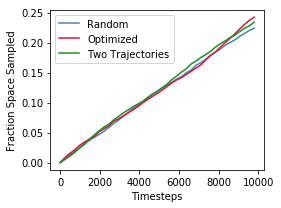

In [42]:
fig, ax = plt.subplots()

ax.plot(steps * traj_time, random_over_time, color='steelblue', label='Random')
ax.plot(steps * traj_time, opt_over_time, color='crimson', label='Optimized')
ax.plot(steps * traj_time, opt2_over_time, color='forestgreen', label='Two Trajectories')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Fraction Space Sampled')

ax.legend()

fig.set_size_inches(4, 3)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'sampling-comparison.png'), dpi=320)

Plot the trajectories

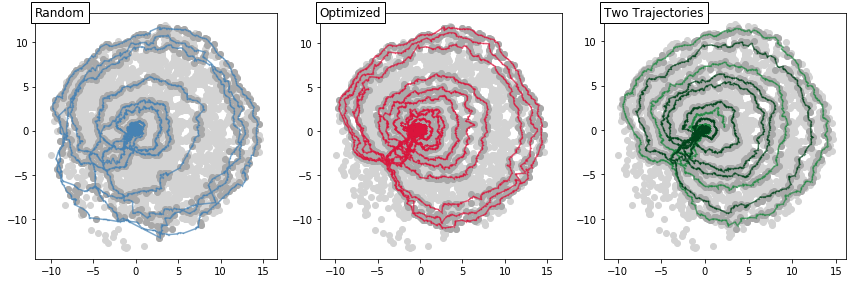

In [43]:
fig, axs = plt.subplots(1, 3)

# Plot the single trajecotires
for ax, traj, c, l in zip(axs, [random_data, opt_data],
                      ['steelblue', 'crimson'],
                      ['Random', 'Optimized']):
    # Get the points the random trajectory and passes near
    hits = get_near_points(traj)

    # Get the projection of the random trajectory
    random_proj = manifold.transform(traj[X_cols])

    # Plot the trajectory
    ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
    ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

    ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7,
           color=c)
    
    # Label it
    ax.text(0, 1, l, va='center', transform=ax.transAxes,
            fontsize=12, bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
# Plot the double trajecotry
cmap = cm.get_cmap('Greens')

# Determine the length of each trajectory
sub_nsteps = int(traj_time / len(opt_trajs))
sub_len = traj_len / len(opt_trajs)

# Initialize the trajectory plot
axs[2].scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')

# Get the points sampled by each trajectory
points = set()
trajs_proj = []
for i,traj in enumerate(opt_trajs):
    # Project the trajectory
    opt2_traj = generate_trajectory(traj[:3], traj[3:], 1, sub_len, sub_nsteps)
    hits = get_near_points(opt2_traj)
    
    # Project the trajectory
    trajs_proj.append(manifold.transform(opt2_traj[X_cols]))
    
    axs[2].scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

# Plot the trajectories (later, so no points are on top)
for i,traj in enumerate(trajs_proj):
    axs[2].plot(traj[:, 0], traj[:, 1], '.-', ms=0.8, alpha=0.7,
               color=cmap((i + 3) / (len(opt_trajs) + 2)))
    
# Label it
axs[2].text(0, 1, 'Two Trajectories', va='center', transform=axs[2].transAxes,
            fontsize=12, bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
    
fig.set_size_inches(12, 4)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'traj_comparison_with_double.png'), dpi=320)